<a href="https://colab.research.google.com/github/maya2d26/CNN_dog_breed_classifier/blob/work/Stanford_dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

# Reading the data

Download and extract images

In [2]:
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
! tar -xf ./images.tar &>/dev/null

--2022-03-02 15:36:18--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  39.2MB/s    in 22s     

2022-03-02 15:36:40 (34.2 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [4]:
!ls /content/Images/ -a

.					  n02100236-German_short-haired_pointer
..					  n02100583-vizsla
n02085620-Chihuahua			  n02100735-English_setter
n02085782-Japanese_spaniel		  n02100877-Irish_setter
n02085936-Maltese_dog			  n02101006-Gordon_setter
n02086079-Pekinese			  n02101388-Brittany_spaniel
n02086240-Shih-Tzu			  n02101556-clumber
n02086646-Blenheim_spaniel		  n02102040-English_springer
n02086910-papillon			  n02102177-Welsh_springer_spaniel
n02087046-toy_terrier			  n02102318-cocker_spaniel
n02087394-Rhodesian_ridgeback		  n02102480-Sussex_spaniel
n02088094-Afghan_hound			  n02102973-Irish_water_spaniel
n02088238-basset			  n02104029-kuvasz
n02088364-beagle			  n02104365-schipperke
n02088466-bloodhound			  n02105056-groenendael
n02088632-bluetick			  n02105162-malinois
n02089078-black-and-tan_coonhound	  n02105251-briard
n02089867-Walker_hound			  n02105412-kelpie
n02089973-English_foxhound		  n02105505-komondor
n02090379-redbone			  n02105641-Old_English_sheepdog
n02090622-borzoi			  n02105855-Shetlan

In [15]:
#choosing the 3 breeds
def isUsed(directory):
  return (os.path.basename(directory) == "n02088364-beagle" 
          or os.path.basename(directory) == "n02110185-Siberian_husky" 
          or os.path.basename(directory) == "n02112018-Pomeranian" )
  
#turning breed names into numbers
def breed_to_num(breed):
  if(breed == "Pomeranian"):
    return 0
  if(breed == "Siberian husky"):
    return 1
  if(breed == "beagle"):
    return 2
  return -1
    

In [28]:
from pathlib import Path
import cv2

images = []
breeds = []
labels = []

root = Path("./Images")
for dir in root.iterdir():
  if (isUsed(dir)):
    for f in dir.iterdir():
      images.append(cv2.cvtColor(cv2.imread(str(f)), cv2.COLOR_BGR2RGB))
      #creating more readable breed labels
      breed = ' '.join(' '.join(dir.name.split('-')[1:]).split('_'))
      breeds.append(breed)
      #using numbers to reperesent breeds
      labels.append(breed_to_num(breed))

df = pd.DataFrame(data={"img": images, "breed": breeds, "label":labels})
df.head()

,img,breed,label
0,"[[[22, 18, 17], [22, 18, 17], [22, 18, 17], [2...",Pomeranian,0
1,"[[[6, 2, 3], [6, 2, 3], [6, 2, 3], [6, 2, 3], ...",Pomeranian,0
2,"[[[172, 171, 166], [172, 171, 166], [172, 171,...",Pomeranian,0
3,"[[[63, 24, 25], [62, 23, 24], [62, 22, 23], [6...",Pomeranian,0
4,"[[[13, 21, 6], [8, 16, 1], [5, 13, 0], [8, 16,...",Pomeranian,0


describing the dataset

In [18]:
print(df["label"][0],df["label"][300],df["label"][600])
print(df["breed"][0],df["breed"][300],df["breed"][600])

0 2 1
Pomeranian beagle Siberian husky


let's see an image!

Siberian husky
500x375


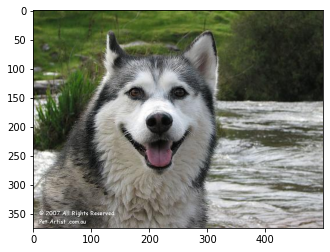

In [30]:
from random import randrange
rnd=randrange(len(df["img"]))
img = df["img"][rnd]
breed = df["breed"][rnd]
print(breed)
height, width, colour = img.shape
print(str(width)+"x"+ str(height))
plt.imshow(img)

# Splitting the data and augmentation

In [33]:
from tqdm import tqdm
from skimage.io import imread, imsave
train_img = []
train_label = []
for idx,row in tqdm(df.iterrows()):
    train_img.append(row["img"])
    train_label.append(row["label"])

train_x_no_aug = np.array(train_img)
train_y_no_aug = np.array(train_label)
train_x_no_aug.shape, train_y_no_aug.shape

606it [00:00, 16889.59it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


((606,), (606,))

splitting the data

In [34]:
from sklearn.model_selection import train_test_split
train_x_no_aug, test_x, train_y_no_aug, test_y = train_test_split(train_x_no_aug, train_y_no_aug, test_size = 0.2, random_state = 13, stratify=train_y_no_aug)
(train_x_no_aug.shape, train_y_no_aug.shape), (test_x.shape, test_y.shape)

(((484,), (484,)), ((122,), (122,)))

augmenting images

In [36]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.7 MB 102 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [37]:
import albumentations as A
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(p=0.2)
])

In [35]:
train_x= []
train_y = []
for i in tqdm(range(train_x_no_aug.shape[0])):
    img = train_x_no_aug[i]
    train_x.append(img)
    train_x.append(img.rotate(60))
    train_x.append(np.fliplr(img.rotate(45)))
    train_x.append(np.fliplr(img))
    train_x.append(np.flipud(img))
    for j in range(5):
      train_y.append(train_y_no_aug[i])

len(train_x), len(train_y)

  0%|          | 0/484 [00:00<?, ?it/s]


AttributeError: ignored

let's see the augmented images!

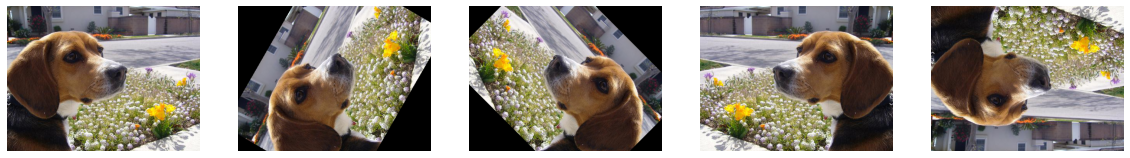

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
dog_num=randrange(484)*5
for i in range(5):
    ax[i].imshow(train_x[i+dog_num])
    ax[i].axis('off')